The FinBERT pretrained model can be fine-tuned on downstream financial NLP tasks. This notebook illustrates the process of fine-tuning FinBERT using Huggingface 🤗's tranformers library. You can modify this notebook accordingly to meet you needs.

In [1]:
!pip install transformers --quiet
!pip install datasets --quiet

     |████████████████████████████████| 4.7 MB 17.9 MB/s 
     |████████████████████████████████| 596 kB 9.7 MB/s 
     |████████████████████████████████| 6.6 MB 30.6 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 
     |████████████████████████████████| 365 kB 12.9 MB/s 
     |████████████████████████████████| 115 kB 57.4 MB/s 
     |████████████████████████████████| 141 kB 20.7 MB/s 
     |████████████████████████████████| 212 kB 55.3 MB/s 
     |████████████████████████████████| 127 kB 48.7 MB/s 


In [2]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

('1.12.0+cu113', '4.21.1')

*Note: the following code is for demonstration purpose. Please use GPU for fast inference on large scale dataset.*

In [4]:
torch.cuda.is_available()

True

### load dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/final_dataset_formatted.csv') ## use your own customized dataset
df_test = pd.read_csv('/content/drive/MyDrive/final_dataset_formatted_test.csv')
df.head()

,sentence,label
0,Product Stewardship Manage potential risks of ...,4
1,CNL and UNDP will develop a coordinated master...,5
2,ChevronTexaco continues to advocate for consis...,0
3,"Maturing oil fields, more technically challeng...",1
4,We found that units in which employees rated t...,3


In [7]:
df = df.dropna(subset=['sentence', 'label']) ## drop missing values
df_test = df_test.dropna(subset=['sentence', 'label']) ## drop missing values

In [8]:
df.shape

(4500, 2)

### prepare training/validation/testing

In [9]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(3645, 2) (450, 2) (405, 2)


### load FinBERT pretrained model
The pretrained FinBERT model path on Huggingface is https://huggingface.co/yiyanghkust/finbert-pretrain

In [10]:
model_name = 'yiyanghkust/finbert-pretrain'

In [11]:
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain',num_labels=9)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

### prepare dataset for fine-tuning

In [12]:
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### **First Trial:** 
### define training options

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels), 'macro-f1' : f1_score(predictions, labels, average='macro')}

In [ ]:
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

trainer.train()   

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3645
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 570


Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,No log,0.610258,0.800000,0.799519
2,No log,0.520416,0.839506,0.836424
3,No log,0.498828,0.851852,0.850855
4,No log,0.530829,0.859259,0.858516
5,0.454000,0.532925,0.849383,0.848495


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

TrainOutput(global_step=570, training_loss=0.4094081435287208, metrics={'train_runtime': 413.1109, 'train_samples_per_second': 44.116, 'train_steps_per_second': 1.38, 'total_flos': 1198875090758400.0, 'train_loss': 0.4094081435287208, 'epoch': 5.0})

### evaluate on validation set

In [ ]:
# generate prediction
predictions = trainer.predict(dataset_val)
print(predictions.metrics, '\n')
y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

# evaluate model performance
f1 = f1_score(predictions[1], y_pred, average='macro')
print('accuracy %s' % accuracy_score(y_pred, predictions[1]))
print(f'macro_f1 score: {f1}')
print(classification_report(predictions[1], y_pred,target_names=labels))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 405
  Batch size = 32


{'test_loss': 0.5308288335800171, 'test_accuracy': 0.8592592592592593, 'test_macro-f1': 0.8585164618366923, 'test_runtime': 2.9505, 'test_samples_per_second': 137.265, 'test_steps_per_second': 4.406} 

accuracy 0.8592592592592593
macro_f1 score: 0.8585164618366923
              precision    recall  f1-score   support

          CC       0.87      0.89      0.88        45
          NC       0.86      0.84      0.85        45
          PW       0.87      0.91      0.89        45
          HC       0.80      0.80      0.80        45
          PL       0.80      0.80      0.80        45
          CR       0.80      0.73      0.77        45
          CG       0.86      0.98      0.92        45
          BE       0.88      0.84      0.86        45
           N       0.98      0.93      0.95        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405



### save the fine-tuned model

In [ ]:
# trainer.save_model('finbert-sentiment/')

## **Fine-Tuning FinBERT Model**  
  
learning_rate   
weight_decay   
num_train_epochs  
per_device_train_batch_size  
per_device_eval_batch_size

In [13]:
# initial hyperparameters settings
learning_rate = 2e-5
weight_decay = 0
num_train_epochs = 5.0
per_device_train_batch_size = 32
per_device_eval_batch_size = 32

### learning_rate

In [ ]:
learning_rate_list = [1e-5, 3e-5, 5e-5, 7e-5, 9e-5]

best_learning_rate = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for learning_rate in learning_rate_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'learning_rate: {learning_rate}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------')  
  acc_list.append(acc)
  macro_f1_list.append(f1)

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_learning_rate = learning_rate

print()
for i in range(len(learning_rate_list)):
  print(f'learning_rate: {learning_rate_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: learning_rate = {best_learning_rate}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.624900,0.938687,0.770370,0.763678
2,0.687300,0.599866,0.827160,0.824744
3,0.425300,0.538154,0.834568,0.832941
4,0.326000,0.515066,0.837037,0.836203
5,0.272100,0.506741,0.846914,0.846059


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

learning_rate: 1e-05
 {'test_loss': 0.5067413449287415, 'test_accuracy': 0.8469135802469135, 'test_macro-f1': 0.8460591973659878, 'test_runtime': 2.9225, 'test_samples_per_second': 138.579, 'test_steps_per_second': 4.448} 

accuracy 0.8469135802469135
macro_f1 score: 0.8460591973659878
              precision    recall  f1-score   support

          CC       0.85      0.89      0.87        45
          NC       0.89      0.87      0.88        45
          PW       0.82      0.93      0.87        45
          HC       0.77      0.80      0.78        45
          PL       0.82      0.71      0.76        45
          CR       0.79      0.76      0.77        45
          CG       0.89      0.93      0.91        45
          BE       0.84      0.82      0.83        45
           N       0.95      0.91      0.93        45

    accuracy                           0.85       405
   macro avg       0.85      0.85      0.85       405
weighted avg       0.85      0.85      0.85       405

--------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.011400,0.541175,0.837037,0.835672
2,0.320200,0.501556,0.856790,0.855433
3,0.149300,0.537148,0.849383,0.849684
4,0.070700,0.591692,0.849383,0.848753
5,0.036800,0.600464,0.851852,0.850752


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

learning_rate: 3e-05
 {'test_loss': 0.5015555620193481, 'test_accuracy': 0.8567901234567902, 'test_macro-f1': 0.8554332425864959, 'test_runtime': 2.9327, 'test_samples_per_second': 138.098, 'test_steps_per_second': 4.433} 

accuracy 0.8567901234567902
macro_f1 score: 0.8554332425864959
              precision    recall  f1-score   support

          CC       0.83      0.89      0.86        45
          NC       0.85      0.89      0.87        45
          PW       0.84      0.93      0.88        45
          HC       0.78      0.80      0.79        45
          PL       0.85      0.78      0.81        45
          CR       0.79      0.69      0.74        45
          CG       0.88      0.96      0.91        45
          BE       0.90      0.82      0.86        45
           N       0.98      0.96      0.97        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405

--------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.838900,0.542318,0.822222,0.820524
2,0.255400,0.477961,0.866667,0.865232
3,0.092200,0.580618,0.861728,0.860862
4,0.031600,0.610449,0.849383,0.849554
5,0.009900,0.623253,0.851852,0.852045


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

learning_rate: 5e-05
 {'test_loss': 0.4779607355594635, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8652322408856377, 'test_runtime': 2.9303, 'test_samples_per_second': 138.21, 'test_steps_per_second': 4.436} 

accuracy 0.8666666666666667
macro_f1 score: 0.8652322408856377
              precision    recall  f1-score   support

          CC       0.83      0.96      0.89        45
          NC       0.89      0.91      0.90        45
          PW       0.86      0.93      0.89        45
          HC       0.85      0.76      0.80        45
          PL       0.83      0.78      0.80        45
          CR       0.80      0.73      0.77        45
          CG       0.88      0.98      0.93        45
          BE       0.86      0.84      0.85        45
           N       1.00      0.91      0.95        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

---------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.765200,0.581873,0.827160,0.824396
2,0.236900,0.543654,0.844444,0.843912
3,0.080600,0.669242,0.844444,0.844026
4,0.019800,0.662362,0.861728,0.861511
5,0.006500,0.663413,0.866667,0.866041


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

learning_rate: 7e-05
 {'test_loss': 0.663412868976593, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8660411669708937, 'test_runtime': 2.9319, 'test_samples_per_second': 138.134, 'test_steps_per_second': 4.434} 

accuracy 0.8666666666666667
macro_f1 score: 0.8660411669708937
              precision    recall  f1-score   support

          CC       0.91      0.91      0.91        45
          NC       0.89      0.87      0.88        45
          PW       0.88      0.93      0.90        45
          HC       0.82      0.80      0.81        45
          PL       0.83      0.76      0.79        45
          CR       0.78      0.78      0.78        45
          CG       0.85      0.91      0.88        45
          BE       0.89      0.89      0.89        45
           N       0.96      0.96      0.96        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

---------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.735100,0.623900,0.814815,0.812457
2,0.244700,0.642751,0.827160,0.826365
3,0.089000,0.621429,0.864198,0.863882
4,0.022400,0.674918,0.864198,0.864501
5,0.006700,0.668588,0.859259,0.859365


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

learning_rate: 9e-05
 {'test_loss': 0.6214293241500854, 'test_accuracy': 0.8641975308641975, 'test_macro-f1': 0.8638818622523636, 'test_runtime': 2.9428, 'test_samples_per_second': 137.624, 'test_steps_per_second': 4.418} 

accuracy 0.8641975308641975
macro_f1 score: 0.8638818622523636
              precision    recall  f1-score   support

          CC       0.93      0.93      0.93        45
          NC       0.87      0.91      0.89        45
          PW       0.91      0.93      0.92        45
          HC       0.79      0.82      0.80        45
          PL       0.89      0.71      0.79        45
          CR       0.78      0.80      0.79        45
          CG       0.80      0.91      0.85        45
          BE       0.85      0.87      0.86        45
           N       0.98      0.89      0.93        45

    accuracy                           0.86       405
   macro avg       0.87      0.86      0.86       405
weighted avg       0.87      0.86      0.86       405

--------

In [ ]:
learning_rate = best_learning_rate

### per_device_train_batch_size & per_device_eval_batch_size

In [ ]:
batch_size_list = [8, 16, 32, 64]

best_batch_size = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for batch_size in batch_size_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'batch_size: {batch_size}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------') 
  acc_list.append(acc)
  macro_f1_list.append(f1) 

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_batch_size = batch_size

print()
for i in range(len(batch_size_list)):
  print(f'batch_size: {batch_size_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: batch_size = {best_batch_size}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.684700,0.583453,0.834568,0.834709
2,0.255600,0.678964,0.859259,0.858786
3,0.088700,0.847522,0.854321,0.854145
4,0.029900,0.868910,0.851852,0.851829
5,0.007600,0.902029,0.859259,0.858723


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 8
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456/config.json
Model weights saved in temp/checkpoint-456/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 8
Saving model checkpoint to temp/checkpoint-912
Configuration saved in temp/checkpoint-912/c

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

batch_size: 8
 {'test_loss': 0.6789635419845581, 'test_accuracy': 0.8592592592592593, 'test_macro-f1': 0.8587863348198308, 'test_runtime': 3.1767, 'test_samples_per_second': 127.489, 'test_steps_per_second': 16.054} 

accuracy 0.8592592592592593
macro_f1 score: 0.8587863348198308
              precision    recall  f1-score   support

          CC       0.87      0.91      0.89        45
          NC       0.93      0.87      0.90        45
          PW       0.86      0.93      0.89        45
          HC       0.82      0.80      0.81        45
          PL       0.73      0.80      0.77        45
          CR       0.87      0.73      0.80        45
          CG       0.83      0.96      0.89        45
          BE       0.90      0.80      0.85        45
           N       0.95      0.93      0.94        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405

--------------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.735300,0.544562,0.824691,0.825088
2,0.234400,0.626387,0.851852,0.850520
3,0.073700,0.714460,0.859259,0.858742
4,0.021300,0.739759,0.866667,0.866847
5,0.009300,0.773540,0.861728,0.861835


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

batch_size: 16
 {'test_loss': 0.7397588491439819, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8668474353283122, 'test_runtime': 2.9191, 'test_samples_per_second': 138.744, 'test_steps_per_second': 8.907} 

accuracy 0.8666666666666667
macro_f1 score: 0.8668474353283122
              precision    recall  f1-score   support

          CC       0.91      0.93      0.92        45
          NC       0.91      0.89      0.90        45
          PW       0.91      0.91      0.91        45
          HC       0.81      0.78      0.80        45
          PL       0.80      0.82      0.81        45
          CR       0.78      0.78      0.78        45
          CG       0.84      0.93      0.88        45
          BE       0.84      0.84      0.84        45
           N       1.00      0.91      0.95        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

--------------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.838900,0.542318,0.822222,0.820524
2,0.255400,0.477961,0.866667,0.865232
3,0.092200,0.580618,0.861728,0.860862
4,0.031600,0.610449,0.849383,0.849554
5,0.009900,0.623253,0.851852,0.852045


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

batch_size: 32
 {'test_loss': 0.4779607355594635, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8652322408856377, 'test_runtime': 2.9231, 'test_samples_per_second': 138.551, 'test_steps_per_second': 4.447} 

accuracy 0.8666666666666667
macro_f1 score: 0.8652322408856377
              precision    recall  f1-score   support

          CC       0.83      0.96      0.89        45
          NC       0.89      0.91      0.90        45
          PW       0.86      0.93      0.89        45
          HC       0.85      0.76      0.80        45
          PL       0.83      0.78      0.80        45
          CR       0.80      0.73      0.77        45
          CG       0.88      0.98      0.93        45
          BE       0.86      0.84      0.85        45
           N       1.00      0.91      0.95        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

--------------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,1.034200,0.545420,0.839506,0.837663
2,0.324400,0.497801,0.844444,0.842876
3,0.142800,0.537230,0.849383,0.848911
4,0.065000,0.578633,0.854321,0.854385
5,0.031700,0.576193,0.859259,0.858591


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 64
Saving model checkpoint to temp/checkpoint-57
Configuration saved in temp/checkpoint-57/config.json
Model weights saved in temp/checkpoint-57/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 64
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/co

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

batch_size: 64
 {'test_loss': 0.5761932730674744, 'test_accuracy': 0.8592592592592593, 'test_macro-f1': 0.8585913082776989, 'test_runtime': 2.933, 'test_samples_per_second': 138.082, 'test_steps_per_second': 2.387} 

accuracy 0.8592592592592593
macro_f1 score: 0.8585913082776989
              precision    recall  f1-score   support

          CC       0.91      0.91      0.91        45
          NC       0.89      0.87      0.88        45
          PW       0.88      0.93      0.90        45
          HC       0.81      0.78      0.80        45
          PL       0.79      0.76      0.77        45
          CR       0.82      0.80      0.81        45
          CG       0.86      0.93      0.89        45
          BE       0.84      0.84      0.84        45
           N       0.93      0.91      0.92        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405

---------------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

RuntimeError: ignored

In [ ]:
# though memory error occurred, best model is batch_size=16, with acc=0.86667, and f1=0.866847
per_device_train_batch_size = 16
per_device_eval_batch_size = 16

### weight_decay

In [ ]:
weight_decay_list = [0, 0.0001, 0.001, 0.01, 0.1]

best_weight_decay = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for weight_decay in weight_decay_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'weight_decay: {weight_decay}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------') 
  acc_list.append(acc)
  macro_f1_list.append(f1)   

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_weight_decay = weight_decay

print()
for i in range(len(weight_decay_list)):
  print(f'weight_decay: {weight_decay_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: weight_decay = {best_weight_decay}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.725200,0.509731,0.837037,0.835360
2,0.231700,0.607128,0.869136,0.867540
3,0.074300,0.725732,0.874074,0.873662
4,0.021200,0.739249,0.861728,0.861387
5,0.007400,0.764860,0.864198,0.864037


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

weight_decay: 0
 {'test_loss': 0.725732147693634, 'test_accuracy': 0.8740740740740741, 'test_macro-f1': 0.873661697273395, 'test_runtime': 2.9731, 'test_samples_per_second': 136.22, 'test_steps_per_second': 8.745} 

accuracy 0.8740740740740741
macro_f1 score: 0.873661697273395
              precision    recall  f1-score   support

          CC       0.91      0.91      0.91        45
          NC       0.91      0.87      0.89        45
          PW       0.89      0.91      0.90        45
          HC       0.84      0.84      0.84        45
          PL       0.80      0.89      0.84        45
          CR       0.82      0.80      0.81        45
          CG       0.81      0.96      0.88        45
          BE       0.94      0.73      0.83        45
           N       0.98      0.96      0.97        45

    accuracy                           0.87       405
   macro avg       0.88      0.87      0.87       405
weighted avg       0.88      0.87      0.87       405

-----------------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.735300,0.544562,0.824691,0.825088
2,0.234400,0.626387,0.851852,0.850520
3,0.073700,0.714460,0.859259,0.858742
4,0.021300,0.739759,0.866667,0.866847
5,0.009300,0.773540,0.861728,0.861835


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

weight_decay: 0.0001
 {'test_loss': 0.7397588491439819, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8668474353283122, 'test_runtime': 2.9403, 'test_samples_per_second': 137.743, 'test_steps_per_second': 8.843} 

accuracy 0.8666666666666667
macro_f1 score: 0.8668474353283122
              precision    recall  f1-score   support

          CC       0.91      0.93      0.92        45
          NC       0.91      0.89      0.90        45
          PW       0.91      0.91      0.91        45
          HC       0.81      0.78      0.80        45
          PL       0.80      0.82      0.81        45
          CR       0.78      0.78      0.78        45
          CG       0.84      0.93      0.88        45
          BE       0.84      0.84      0.84        45
           N       1.00      0.91      0.95        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

--------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.735300,0.544562,0.824691,0.825088
2,0.234400,0.626386,0.851852,0.850520
3,0.073700,0.714481,0.859259,0.858742
4,0.021200,0.740799,0.866667,0.866847
5,0.009400,0.774360,0.861728,0.861835


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

weight_decay: 0.001
 {'test_loss': 0.740799069404602, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8668474353283122, 'test_runtime': 2.9346, 'test_samples_per_second': 138.009, 'test_steps_per_second': 8.86} 

accuracy 0.8666666666666667
macro_f1 score: 0.8668474353283122
              precision    recall  f1-score   support

          CC       0.91      0.93      0.92        45
          NC       0.91      0.89      0.90        45
          PW       0.91      0.91      0.91        45
          HC       0.81      0.78      0.80        45
          PL       0.80      0.82      0.81        45
          CR       0.78      0.78      0.78        45
          CG       0.84      0.93      0.88        45
          BE       0.84      0.84      0.84        45
           N       1.00      0.91      0.95        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

-----------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.735300,0.544558,0.824691,0.825088
2,0.234400,0.626357,0.851852,0.850520
3,0.073800,0.714675,0.859259,0.858742
4,0.020700,0.745680,0.869136,0.869335
5,0.010000,0.778457,0.856790,0.856965


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

weight_decay: 0.01
 {'test_loss': 0.7456800937652588, 'test_accuracy': 0.8691358024691358, 'test_macro-f1': 0.8693350223461059, 'test_runtime': 2.9611, 'test_samples_per_second': 136.773, 'test_steps_per_second': 8.78} 

accuracy 0.8691358024691358
macro_f1 score: 0.8693350223461059
              precision    recall  f1-score   support

          CC       0.91      0.93      0.92        45
          NC       0.91      0.89      0.90        45
          PW       0.91      0.91      0.91        45
          HC       0.81      0.78      0.80        45
          PL       0.81      0.84      0.83        45
          CR       0.78      0.78      0.78        45
          CG       0.84      0.93      0.88        45
          BE       0.86      0.84      0.85        45
           N       1.00      0.91      0.95        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

-----------

loading weights file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/f0f259830c52369dfd874be436f2f8106ff53d563cd04462ecf2cafe5ec8c4c7.587885ce9bf0920100db493163208c850d88adf23165c8f8824693457e6d404e
Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializ

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.735400,0.544503,0.822222,0.822471
2,0.234400,0.625975,0.854321,0.853171
3,0.074000,0.719191,0.856790,0.856206
4,0.020300,0.750126,0.866667,0.866967
5,0.009900,0.776785,0.859259,0.859499


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

weight_decay: 0.1
 {'test_loss': 0.750126302242279, 'test_accuracy': 0.8666666666666667, 'test_macro-f1': 0.8669672443839759, 'test_runtime': 2.977, 'test_samples_per_second': 136.044, 'test_steps_per_second': 8.734} 

accuracy 0.8666666666666667
macro_f1 score: 0.8669672443839759
              precision    recall  f1-score   support

          CC       0.91      0.93      0.92        45
          NC       0.91      0.89      0.90        45
          PW       0.91      0.91      0.91        45
          HC       0.83      0.78      0.80        45
          PL       0.79      0.84      0.82        45
          CR       0.76      0.78      0.77        45
          CG       0.84      0.93      0.88        45
          BE       0.86      0.82      0.84        45
           N       1.00      0.91      0.95        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

-------------

In [ ]:
weight_decay = best_weight_decay

### num_train_epochs

In [17]:
num_train_epochs_list = [3, 4, 5, 6, 7, 8]

best_num_train_epochs = 0
best_acc = 0
best_macro_f1 = 0

acc_list = list()
macro_f1_list = list()

for num_train_epochs in num_train_epochs_list:
  # reload pre-trained model
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

  # set training arguments
  args = TrainingArguments(
          output_dir = 'temp/',
          evaluation_strategy = 'epoch',
          save_strategy = 'epoch',
          logging_strategy='epoch',
          learning_rate=learning_rate,
          per_device_train_batch_size=per_device_train_batch_size,
          per_device_eval_batch_size=per_device_eval_batch_size,
          num_train_epochs=num_train_epochs,
          weight_decay=weight_decay,
          load_best_model_at_end=True,
          metric_for_best_model='accuracy',
  )

  # set trainer
  trainer = Trainer(
          model=model,                         # the instantiated 🤗 Transformers model to be trained
          args=args,                  # training arguments, defined above
          train_dataset=dataset_train,         # training dataset
          eval_dataset=dataset_val,            # evaluation dataset
          compute_metrics=compute_metrics
  )

  # train model
  trainer.train() 

  # generate prediction
  predictions = trainer.predict(dataset_val)
  print(f'num_train_epochs: {num_train_epochs}\n', predictions.metrics, '\n')
  y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

  # evaluate model performance
  acc = accuracy_score(y_pred, predictions[1])
  f1 = f1_score(predictions[1], y_pred, average='macro')
  print(f'accuracy {acc}')
  print(f'macro_f1 score: {f1}')
  print(classification_report(predictions[1], y_pred,target_names=labels))
  print('------------------------------------------------------------------------------------------------------')
  acc_list.append(acc)
  macro_f1_list.append(f1)  

  # save best model hyperparameter
  if best_acc < acc:
    best_acc = acc
    best_macro_f1 = f1
    best_num_train_epochs = num_train_epochs

print()
for i in range(len(num_train_epochs_list)):
  print(f'num_train_epochs: {num_train_epochs_list[i]}, acc: {acc_list[i]}, macro-f1: {macro_f1_list[i]}')
print()
print(f'Best Model: num_train_epochs = {best_num_train_epochs}, acc = {best_acc}, macro-f1 = {best_macro_f1}')

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.754400,0.527542,0.824691,0.823767
2,0.214100,0.561514,0.851852,0.851546
3,0.066200,0.615290,0.859259,0.858800


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 3
 {'test_loss': 0.6152901649475098, 'test_accuracy': 0.8592592592592593, 'test_macro-f1': 0.858799506193225, 'test_runtime': 3.1432, 'test_samples_per_second': 128.85, 'test_steps_per_second': 8.272} 

accuracy 0.8592592592592593
macro_f1 score: 0.858799506193225
              precision    recall  f1-score   support

          CC       0.91      0.91      0.91        45
          NC       0.85      0.87      0.86        45
          PW       0.87      0.91      0.89        45
          HC       0.82      0.80      0.81        45
          PL       0.80      0.78      0.79        45
          CR       0.81      0.76      0.78        45
          CG       0.89      0.93      0.91        45
          BE       0.80      0.82      0.81        45
           N       0.98      0.96      0.97        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405

------------

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.730800,0.520627,0.829630,0.828703
2,0.225500,0.551044,0.861728,0.861146
3,0.062600,0.695991,0.856790,0.856060
4,0.015600,0.693469,0.849383,0.849242


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 4
 {'test_loss': 0.5510438084602356, 'test_accuracy': 0.8617283950617284, 'test_macro-f1': 0.8611460258390083, 'test_runtime': 3.0145, 'test_samples_per_second': 134.352, 'test_steps_per_second': 8.625} 

accuracy 0.8617283950617284
macro_f1 score: 0.8611460258390083
              precision    recall  f1-score   support

          CC       0.91      0.91      0.91        45
          NC       0.91      0.87      0.89        45
          PW       0.86      0.96      0.91        45
          HC       0.76      0.87      0.81        45
          PL       0.87      0.76      0.81        45
          CR       0.80      0.80      0.80        45
          CG       0.84      0.93      0.88        45
          BE       0.87      0.76      0.81        45
           N       0.95      0.91      0.93        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405

---------

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.732200,0.551671,0.819753,0.819106
2,0.229800,0.643182,0.854321,0.853126
3,0.080800,0.745165,0.864198,0.863617
4,0.023900,0.796835,0.856790,0.855783
5,0.006300,0.822451,0.856790,0.856269


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 5
 {'test_loss': 0.7451650500297546, 'test_accuracy': 0.8641975308641975, 'test_macro-f1': 0.8636166878617147, 'test_runtime': 2.9977, 'test_samples_per_second': 135.104, 'test_steps_per_second': 8.673} 

accuracy 0.8641975308641975
macro_f1 score: 0.8636166878617147
              precision    recall  f1-score   support

          CC       0.89      0.91      0.90        45
          NC       0.86      0.84      0.85        45
          PW       0.89      0.89      0.89        45
          HC       0.79      0.82      0.80        45
          PL       0.82      0.82      0.82        45
          CR       0.81      0.78      0.80        45
          CG       0.88      0.93      0.90        45
          BE       0.92      0.80      0.86        45
           N       0.92      0.98      0.95        45

    accuracy                           0.86       405
   macro avg       0.86      0.86      0.86       405
weighted avg       0.86      0.86      0.86       405

---------

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.735600,0.549178,0.817284,0.817363
2,0.238800,0.625005,0.851852,0.851040
3,0.077400,0.693817,0.864198,0.863955
4,0.022500,0.787160,0.864198,0.864440
5,0.010000,0.828920,0.866667,0.866693
6,0.001300,0.823678,0.871605,0.871687


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 6
 {'test_loss': 0.8236783146858215, 'test_accuracy': 0.8716049382716049, 'test_macro-f1': 0.8716868261275657, 'test_runtime': 3.0004, 'test_samples_per_second': 134.981, 'test_steps_per_second': 8.665} 

accuracy 0.8716049382716049
macro_f1 score: 0.8716868261275657
              precision    recall  f1-score   support

          CC       0.89      0.93      0.91        45
          NC       0.87      0.91      0.89        45
          PW       0.91      0.91      0.91        45
          HC       0.80      0.80      0.80        45
          PL       0.76      0.84      0.80        45
          CR       0.85      0.76      0.80        45
          CG       0.86      0.93      0.89        45
          BE       0.93      0.82      0.87        45
           N       1.00      0.93      0.97        45

    accuracy                           0.87       405
   macro avg       0.87      0.87      0.87       405
weighted avg       0.87      0.87      0.87       405

---------

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.738600,0.531363,0.844444,0.844713
2,0.243500,0.547874,0.851852,0.850993
3,0.092700,0.711663,0.864198,0.863051
4,0.023900,0.824649,0.856790,0.856920
5,0.006000,0.843759,0.861728,0.861053
6,0.001000,0.844743,0.856790,0.856403
7,0.000700,0.846708,0.851852,0.851500


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 7
 {'test_loss': 0.7116634249687195, 'test_accuracy': 0.8641975308641975, 'test_macro-f1': 0.863050898296694, 'test_runtime': 3.0015, 'test_samples_per_second': 134.932, 'test_steps_per_second': 8.662} 

accuracy 0.8641975308641975
macro_f1 score: 0.863050898296694
              precision    recall  f1-score   support

          CC       0.88      0.93      0.90        45
          NC       0.93      0.87      0.90        45
          PW       0.89      0.89      0.89        45
          HC       0.76      0.82      0.79        45
          PL       0.84      0.82      0.83        45
          CR       0.86      0.69      0.77        45
          CG       0.84      0.93      0.88        45
          BE       0.86      0.84      0.85        45
           N       0.94      0.98      0.96        45

    accuracy                           0.86       405
   macro avg       0.87      0.86      0.86       405
weighted avg       0.87      0.86      0.86       405

-----------

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.752000,0.514962,0.846914,0.846988
2,0.246600,0.581957,0.859259,0.859096
3,0.096800,0.729848,0.859259,0.859987
4,0.027300,0.822255,0.864198,0.864253
5,0.009100,0.845877,0.856790,0.856031
6,0.004500,0.893967,0.849383,0.848845
7,0.000600,0.891131,0.854321,0.854016
8,0.000700,0.894380,0.854321,0.854016


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 8
 {'test_loss': 0.8222550749778748, 'test_accuracy': 0.8641975308641975, 'test_macro-f1': 0.8642534837138766, 'test_runtime': 3.0043, 'test_samples_per_second': 134.806, 'test_steps_per_second': 8.654} 

accuracy 0.8641975308641975
macro_f1 score: 0.8642534837138766
              precision    recall  f1-score   support

          CC       0.86      0.93      0.89        45
          NC       0.93      0.87      0.90        45
          PW       0.91      0.87      0.89        45
          HC       0.83      0.84      0.84        45
          PL       0.78      0.80      0.79        45
          CR       0.81      0.76      0.78        45
          CG       0.84      0.96      0.90        45
          BE       0.84      0.84      0.84        45
           N       1.00      0.91      0.95        45

    accuracy                           0.86       405
   macro avg       0.87      0.86      0.86       405
weighted avg       0.87      0.86      0.86       405

---------

In [18]:
num_train_epochs = best_num_train_epochs

## **Final Model Training**

In [29]:
# best hyperparameters values
learning_rate = 5e-5
per_device_train_batch_size = per_device_eval_batch_size = 16
num_train_epochs = 6
weight_decay = 0

In [23]:
# reload pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=9)

# set training arguments
args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        logging_strategy='epoch',
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

# set trainer
trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

# train model
trainer.train() 

# generate validation set prediction
predictions = trainer.predict(dataset_val)
print(f'num_train_epochs: {num_train_epochs}\n', predictions.metrics, '\n')
y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

# evaluate model performance on validation set
acc = accuracy_score(y_pred, predictions[1])
f1 = f1_score(predictions[1], y_pred, average='macro')
print(f'accuracy {acc}')
print(f'macro_f1 score: {f1}')
print(classification_report(predictions[1], y_pred,target_names=labels))

loading configuration file https://huggingface.co/yiyanghkust/finbert-pretrain/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/52a95139f4c3367976e7045d2f955bf82242a485e8506539b49838ca3c825654.ddd3650c75e2551777ba1291415522ee7288b429a28ea24681ddf54025802027
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings":

Epoch,Training Loss,Validation Loss,Accuracy,Macro-f1
1,0.716200,0.599196,0.817284,0.815531
2,0.236000,0.569624,0.859259,0.858186
3,0.084900,0.700161,0.856790,0.855414
4,0.019900,0.693320,0.864198,0.864312
5,0.007000,0.725072,0.861728,0.861639
6,0.002100,0.755248,0.856790,0.857633


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228/config.json
Model weights saved in temp/checkpoint-228/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 16
Saving model checkpoint to temp/checkpoint-456
Configuration saved in temp/checkpoint-456

num_train_epochs: 6
 {'test_loss': 0.6933199763298035, 'test_accuracy': 0.8641975308641975, 'test_macro-f1': 0.8643115933603842, 'test_runtime': 2.9855, 'test_samples_per_second': 135.655, 'test_steps_per_second': 8.709} 

accuracy 0.8641975308641975
macro_f1 score: 0.8643115933603842
              precision    recall  f1-score   support

          CC       0.89      0.91      0.90        45
          NC       0.93      0.87      0.90        45
          PW       0.89      0.89      0.89        45
          HC       0.77      0.82      0.80        45
          PL       0.85      0.87      0.86        45
          CR       0.77      0.76      0.76        45
          CG       0.86      0.96      0.91        45
          BE       0.86      0.80      0.83        45
           N       0.98      0.91      0.94        45

    accuracy                           0.86       405
   macro avg       0.87      0.86      0.86       405
weighted avg       0.87      0.86      0.86       405



## **Prediction on Test Dataset**

In [24]:
# generate prediction
predictions = trainer.predict(dataset_test)
y_pred = np.array([np.argmax(pred) for pred in predictions[0]])

# evaluate model performance
f1 = f1_score(predictions[1], y_pred, average='macro')
print('accuracy %s' % accuracy_score(y_pred, predictions[1]))
print(f'macro_f1 score: {f1}')
print(classification_report(predictions[1], y_pred,target_names=labels))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 16


accuracy 0.8977777777777778
macro_f1 score: 0.8980669013686238
              precision    recall  f1-score   support

          CC       0.89      0.98      0.93        50
          NC       0.90      0.94      0.92        50
          PW       0.94      0.90      0.92        50
          HC       0.90      0.86      0.88        50
          PL       0.84      0.86      0.85        50
          CR       0.93      0.86      0.90        50
          CG       0.98      0.88      0.93        50
          BE       0.80      0.90      0.85        50
           N       0.92      0.90      0.91        50

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.90      0.90      0.90       450



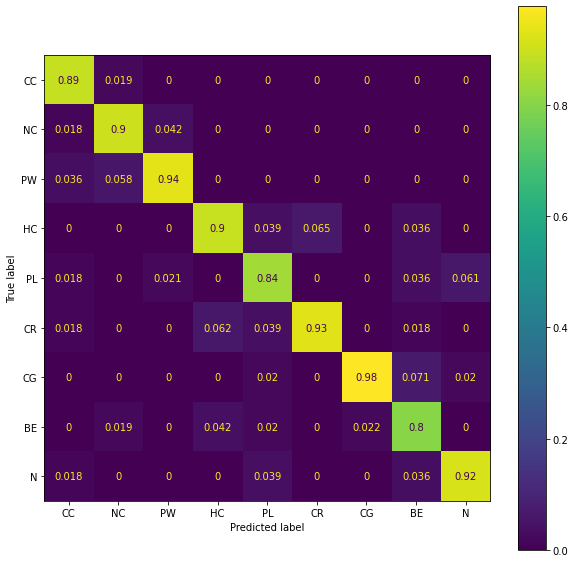

In [25]:
# plot confusion matrix
cm = confusion_matrix(predictions[1], y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)